#### DICOM imgages
(C) MK & ASL & AL

Created: 2019.11.11

Modified: 2019.11.21

In [68]:
import os
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt

# my imports
import mkViewer2A as mkv
import functions1 as f1
import functions2 as f2

import imp
imp.reload(f1)

<module 'functions1' from '/media/mk/p1ext4/codes/adni_basics/functions1.py'>

#### Main script 

In [48]:
# setting main paths
adniPth = os.path.join('/','media','mk','p1ext4','no19','adni')
adniMainPth = os.path.join(adniPth, 'ADNI_from_Alexander', 'DownloadedNIfTI')
folder = os.path.join(adniMainPth, 'ADNI')

# paths to image and statistic folders

# image; ~170 x 2D DICOM slices ---> a 3D NPY arrays - for each acquisition
dcm2npyPth = os.path.join(adniMainPth, 'DCM2NPY')  
# array for each acquisition; stat. params for each 2D DICOM image (~170 rows x 4 columns)
statslPth = os.path.join(adniMainPth, 'STATSL') 
# array for each acquisition; stats for one 3D image (4,)
statim3dPth = os.path.join(adniMainPth, 'STATIM3D') 

# A global variable
PRINT = False

os.chdir(folder)
pthInfo()

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/ADNI


##### Number of all subject folders in my database (ADNI) - 1488 objects

In [49]:
! ls | wc -l

1488


##### Number of all *.dcm in subfolders

In [50]:
!find . -type f -iname "*.dcm" | wc -l

305613


##### A tree structure in ADNI folders

"""
Folder tree structure in ADNI data folder


    ---> ADNI
        ---> SUBJECT (002_S_0295)  
            ---> MT1__N3m
            ---> MP-RAGE
            ---> MPRAGE                
                    ---> 2009-04-30_10_58_19.0
                                ---> S666999
                                        ---> DCM files (x 170)
    
"""

##### Convertion from 2D DICOMs to one 3D NPY array

In [60]:
# Walk through a folder tree in ADNI directory
# and converts 2D DICOM slices in into one 3D NPY array in each subfolder

os.chdir(folder)
pthInfo()
# pth to current dir
curDir = os.getcwd()

# find all subjects
subDirs = os.listdir('.')
subDirs = [d for d in subDirs if os.path.isdir(d)]
subDirs.sort()
subCnt = 0

nameToFind = 'rage'

# an limitation of processed folders
dirsToProcess = 100

# go into subject dir 
for sub in subDirs[:dirsToProcess]: 
    subCnt += 1
    # print progress
    f1.progress(subCnt, dirsToProcess)
    
    os.chdir(sub)
    examsDir = os.listdir('.')
    examsDir = [d for d in examsDir if os.path.isdir(d)]
    examsDir = [d for d in examsDir if nameToFind in d.lower()]
    
    for exam in examsDir:
        os.chdir(exam)
        dateDirs = os.listdir('.')
        for date in dateDirs:
            os.chdir(date)
            sDirs = os.listdir('.')
            for s in sDirs:
                os.chdir(s)
                dcmFiles = os.listdir('.')
                dcmFiles = [f for f in dcmFiles if f.lower().endswith('.dcm')]
                
                ##########################################
                # here should be a main part of the algorithm

                # convertion from DICOM to Nifti
                saveName = "{}-{}.npy".format(sub, s)
                if PRINT:
                    text_wrap(saveName)
                savePth = os.path.join(dcm2npyPth, saveName) # DCM2NPY folder
                im3dx = f2.convertDICOM2NPY(savePth)  
                
                ##########################################             
                
                # go up from s
                os.chdir('../')
            # go up from date
            os.chdir('../')    
        # go up form exam
        os.chdir('../')    
    # go up from sub
    os.chdir('../')

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/ADNI


---

#### Image statisitcs based on 3D NPY arrays

In [70]:
# loads 3D NPY arrays with pixel values from series of 2D DICOM slices,
# counts and save their statistics to dedicated folders

os.chdir(dcm2npyPth)
pthInfo()

npy_files = os.listdir('.')
npy_files.sort()

cnt = 0
for f in npy_files:   
    cnt+=1
    cnt_full = len(npy_files)
    f1.progress(cnt, cnt_full)
    
    name, ext = os.path.splitext(f)
    # create a file name with two parts: subject and this "Sxxxx" (?)
    sub, s = name.split('-')

    im3dd = np.load(f)
    # each name receives an prefix
    saveNameSL = "{}-{}-{}.npy".format(sub, s, 'statSL')
    savePthSL = os.path.join(statslPth, saveNameSL)                
    saveNameIm3d = "{}-{}-{}.npy".format(sub, s, 'statIm3d')
    savePthIm3d = os.path.join(statim3dPth, saveNameIm3d)
    # pass loaded 3D data to get/count parameters
    f2.getStatistics(im3dd, savePthSL, savePthIm3d)
    

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/DCM2NPY


#### Plot statistic parameter values for 2D slices - without normalization

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/STATSL


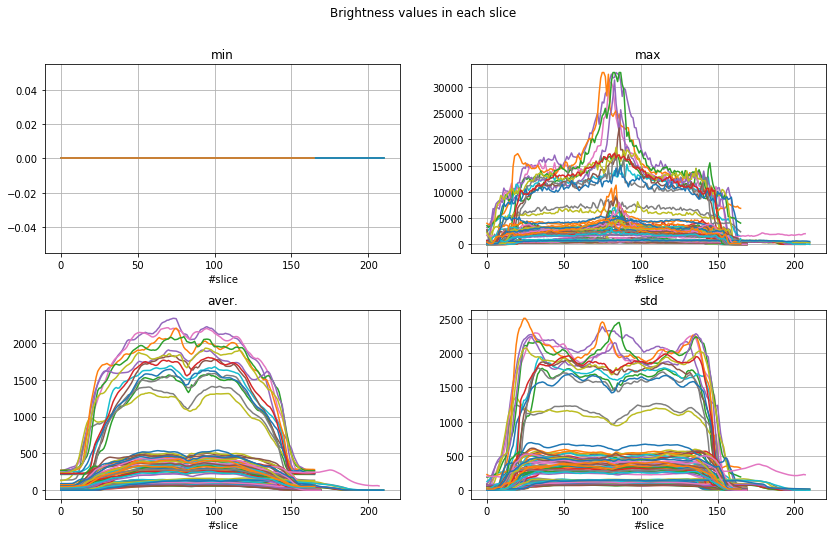

In [39]:
# plot of all slice statistisc from a STATSL folder
#%matplotlib qt
%matplotlib inline
os.chdir(statslPth)
pthInfo()

sl_files = os.listdir('.')
sl_files.sort()

f, ax = plt.subplots(2,2, figsize=(14,8))
plt.suptitle('Brightness values in each slice')
plt.subplots_adjust(hspace=0.3)

for k, f in enumerate(sl_files):
    statSL = np.load(f)
    
    mn = statSL[:,0]
    mx = statSL[:,1]
    av = statSL[:,2]
    st = statSL[:,3]
    
    ax[0,0].plot(mn)
    ax[0,0].axes.grid(True)
    ax[0,0].set_title('min')   
    ax[0,0].set_xlabel('#slice')
    
    ax[0,1].plot(mx)
    ax[0,1].axes.grid(True)
    ax[0,1].set_title('max')   
    ax[0,1].set_xlabel('#slice')
   
    ax[1,0].plot(av)
    ax[1,0].axes.grid(True)
    ax[1,0].set_title('aver.') 
    ax[1,0].set_xlabel('#slice')
    
    ax[1,1].plot(st)
    ax[1,1].axes.grid(True)
    ax[1,1].set_title('std')
    ax[1,1].set_xlabel('#slice')

#### Scatter plots for 3D image statisitcs

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/STATIM3D


Text(0.5, 0, '#subject')

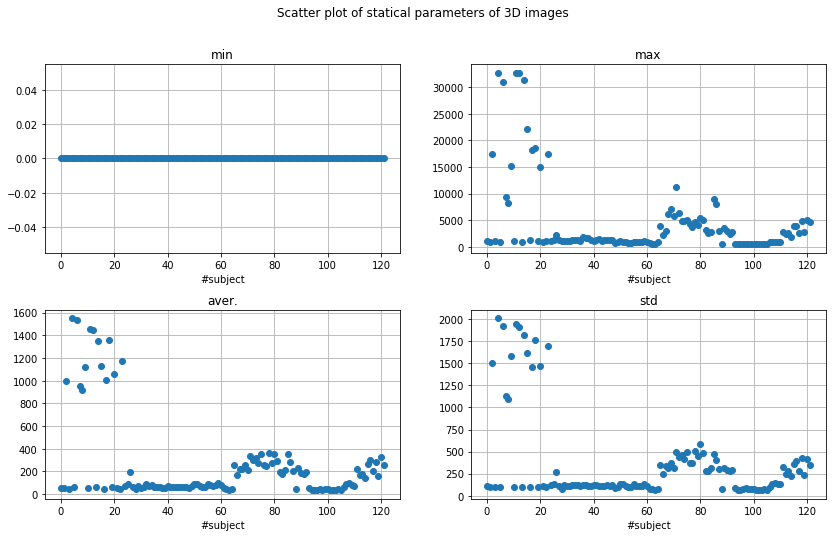

In [40]:
os.chdir(statim3dPth)
pthInfo()

d3_files = os.listdir('.')
d3_files.sort()

stat_all = np.zeros((len(d3_files),4), dtype=np.float32)

for k,f in enumerate(d3_files):
    stat = np.load(f)
    stat_all[k]= stat
       
    
f, ax = plt.subplots(2,2, figsize=(14,8))
plt.suptitle('Scatter plot of statical parameters of 3D images')
plt.subplots_adjust(hspace=0.3)

ax[0,0].plot(stat_all[:,0], 'o')
ax[0,0].axes.grid(True)
ax[0,0].set_title('min')   
ax[0,0].set_xlabel('#subject')

ax[0,1].plot(stat_all[:,1], 'o')
ax[0,1].axes.grid(True)
ax[0,1].set_title('max')   
ax[0,1].set_xlabel('#subject')

ax[1,0].plot(stat_all[:,2], 'o')
ax[1,0].axes.grid(True)
ax[1,0].set_title('aver.')
ax[1,0].set_xlabel('#subject')

ax[1,1].plot(stat_all[:,3], 'o')
ax[1,1].axes.grid(True)
ax[1,1].set_title('std')
ax[1,1].set_xlabel('#subject')

#### 3D scatter plot 

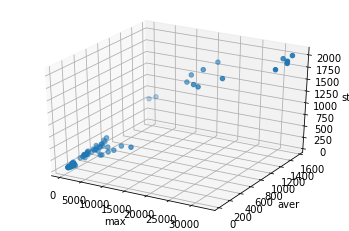

In [41]:
if 0: 
    %matplotlib qt5    
else:
    %matplotlib inline
    
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = stat_all[:,1]
ys = stat_all[:,2]
zs = stat_all[:,3]
ax.scatter(xs, ys, zs)
ax.set_xlabel('max')
ax.set_ylabel('aver')
ax.set_zlabel('std')

plt.show()

---

#### Visualization

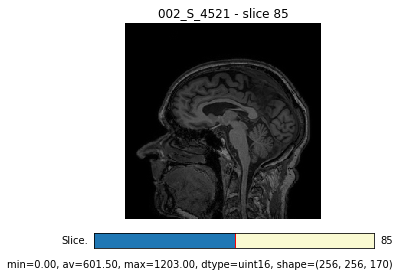

In [33]:
# display numpy image
if 0: 
    %matplotlib qt5    
else:
    %matplotlib inline
import mkViewer2A as mkv
tracker = mkv.IndexTracker(im3dd, 'gray', title=sub, rot=False)